# LSTM_Stock_Prediction


給定 2010 ~ 2016 紐約股市的資料：

1. `stt.csv`：State Street Corp (STT) 的資料。
2. `all.csv`：STT 以外其他公司的資料。

csv 中每一行有以下欄位：

1. `date`：日期
2. `symbol`: 公司
3. `open`：開盤價
4. `close`：收盤價
5. `low`：低點
6. `hight`：高點
7. `volume`：交易量

作業如下：

1. 使用 STT 前 15 天的資料來預測第 16 天的交易量(30%)
2. 使用所有跟 STT 同領域的公司前 15 天的資料來預測 STT 第 16 天的收盤價(30%)
3. 使用整個股市的資料前 30 天的資料來預測第 31 天的開盤價(40%)


### 以下範例程式使用STT過去15天的`open`、`close`、`low`和`volume`（without  `high`），來預測STT第16天的最高價（`high`）。

## Task:

1. Use a RNN/LSTM.
2. Plot the loss curve.
3. Report the $MSE$ between your predictions and groundtruths. (both train and valid set)

$$
MSE = \frac{1}{N} \sum_1^N (p_i - q_i)^2
$$
4. Plot the prediction vs groundtruth. (both train and valid set)


where $N$ is number of days and $p_i, q_i$ are the prediction and groudtruth on day $i$ respectively.


## Download Data and Import Libraries

In [1]:
from pathlib import Path
from torchvision.datasets.utils import download_file_from_google_drive

csv_path_stt = Path('./stt.csv')
csv_path_all = Path('./all.csv')

if not csv_path_stt.exists():
    download_file_from_google_drive('1zY26f3Ie5c7Vt9R0wHRz9hGldOsizV4b', '.', csv_path_stt)
if not csv_path_all.exists():
    download_file_from_google_drive('1KtyafQZRtx3FOWpFEe-keoeiVTb2y7Fu', '.', csv_path_all)

Downloading...
From: https://drive.google.com/uc?id=1zY26f3Ie5c7Vt9R0wHRz9hGldOsizV4b
To: /content/stt.csv
100%|██████████| 112k/112k [00:00<00:00, 29.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KtyafQZRtx3FOWpFEe-keoeiVTb2y7Fu
To: /content/all.csv
100%|██████████| 54.5M/54.5M [00:00<00:00, 129MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from sklearn.preprocessing import StandardScaler

In [3]:
df_stt = pd.read_csv(csv_path_stt)      # a DataFrame object
df_stt = df_stt.sort_values(by='date')  # csv are not guarenteed to be ordered by date
df_stt.head(10)

,date,symbol,open,close,low,high,volume
0,2010-01-04,STT,43.810001,44.459999,43.549999,44.779999,3440300.0
1,2010-01-05,STT,44.520000,44.549999,44.020000,45.000000,3992500.0
2,2010-01-06,STT,44.400002,43.810001,43.650002,44.669998,4062100.0
3,2010-01-07,STT,44.349998,44.599998,43.980000,44.860001,5273100.0
4,2010-01-08,STT,44.759998,45.509998,44.389999,45.880001,6038000.0
5,2010-01-11,STT,45.889999,44.360001,44.209999,46.099998,4260000.0
6,2010-01-12,STT,43.910000,44.200001,43.910000,44.849998,3432600.0
7,2010-01-13,STT,44.500000,44.610001,43.650002,44.770000,2741000.0
8,2010-01-14,STT,44.330002,43.790001,43.189999,44.419998,4268500.0
9,2010-01-15,STT,43.520000,42.669998,42.520000,44.099998,6887100.0


In [4]:
df_all = pd.read_csv(csv_path_all)      # a DataFrame object
df_ual = df_all[df_all['symbol'] == 'UAL']
df_ual = df_ual.sort_values(by='date')  # csv are not guarenteed to be ordered by date
df_ual.head(10)

,date,symbol,open,close,low,high,volume
667,2010-01-04,UAL,12.99,12.80,12.53,13.11,8785900.0
1134,2010-01-05,UAL,12.87,13.91,12.87,14.10,23646300.0
1601,2010-01-06,UAL,13.74,13.27,13.13,13.99,15398700.0
2068,2010-01-07,UAL,13.20,13.55,13.20,13.95,10177000.0
2535,2010-01-08,UAL,13.56,13.33,13.13,13.86,5896400.0
3002,2010-01-11,UAL,13.36,13.11,12.66,13.42,10168600.0
3469,2010-01-12,UAL,13.00,12.69,12.59,13.16,7203300.0
3936,2010-01-13,UAL,12.75,13.95,12.53,14.05,25097400.0
4403,2010-01-14,UAL,13.84,13.93,13.65,14.11,8794300.0
4870,2010-01-15,UAL,13.93,13.25,13.22,14.07,10210700.0


### Train/Valid Split and Feature Normalization

We split first 85% of the entries to be training data, and last 15% to be validation data.
The pivot date is 2015-12-15, i.e., entries after 2015-12-15 (included) is valid data.


Note that scale of the features (`open`, `close`, `low`, `high`, `volume`) are different to each other. In practice, we normalize each features to better train our model. If we do so, the model will suffer gradient vanishment/exploding.

To normalize data, common techniques are:

1. Standard Scaler: $x_{new} = (x - mean) / std$
2. Minmax Scaler: $x_{new} = (x - x_{min}) / (x_{max} - x_{min})$

Both are implemented in `sklearn`. In this code, we use the first one.

**Be careful that when normalizing data, we can use only training data to compute the statistics. Using validation/testing data is not allowed.**


In some cases, we need to obtain original values from normalized features, we can do it using the standard scaler `std` used for normalization.

```python
raw_open = normalize_open* std.scale_[0] + std.mean_[0]
raw_close = normalized_close * std.scale_[1] + std.mean_[1]
raw_low = normalized_low * std.scale_[2] + std.mean_[2]
raw_high = normalized_low * std.scale_[3] + std.mean_[3]
raw_volume = normalized_low * std.scale_[4] + std.mean_[4]
```

In [5]:
pivot = round(0.85 * len(df_ual))
#print('pivot:', df_ual.loc[pivot, 'date'])

df_train = df_ual[:pivot].copy()    # DataFrame
df_valid = df_ual[pivot:].copy()    # DataFrame
df_test = df_stt.copy()

FEATURES = ['open', 'close', 'low', 'high', 'volume']
std = StandardScaler().fit(df_train[FEATURES])
df_train[FEATURES] = std.transform(df_train[FEATURES])
df_valid[FEATURES] = std.transform(df_valid[FEATURES])
df_test[FEATURES] = std.transform(df_test[FEATURES])

df_train.head(10)

,date,symbol,open,close,low,high,volume
667,2010-01-04,UAL,-1.339408,-1.353177,-1.350487,-1.353651,0.707887
1134,2010-01-05,UAL,-1.347168,-1.281286,-1.328160,-1.290444,4.692716
1601,2010-01-06,UAL,-1.290906,-1.322736,-1.311086,-1.297467,2.481115
2068,2010-01-07,UAL,-1.325828,-1.304602,-1.306489,-1.300021,1.080911
2535,2010-01-08,UAL,-1.302547,-1.318851,-1.311086,-1.305767,-0.066935
3002,2010-01-11,UAL,-1.315481,-1.333099,-1.341950,-1.333859,1.078659
3469,2010-01-12,UAL,-1.338761,-1.360301,-1.346547,-1.350458,0.283511
3936,2010-01-13,UAL,-1.354929,-1.278695,-1.350487,-1.293636,5.081830
4403,2010-01-14,UAL,-1.284439,-1.279991,-1.276938,-1.289806,0.710139
4870,2010-01-15,UAL,-1.278619,-1.324032,-1.305175,-1.292359,1.089948


# Dataset

To predict the stock on day 16 based on day 1 ~ day 15 features, we expect each sample contains:

1. `feature`: the features of day 1 ~ 15. Each day has 4 features, thus the shape is `[15, 4]`.
2. `target`: the target we are predicting. In this case, it's the `high` of day 16, thus `target` is a shaped `[1]`.

Therefore we are performing a *sliding window*-like operation on the given dataframe.

In [6]:
class CompanyStockData(Dataset):
    def __init__(self, dataframe, window=10):
        super().__init__()
        self.df = dataframe
        self.window = window

    def __len__(self):
        return len(self.df) - self.window

    def __getitem__(self, idx):
        window_s = idx
        window_t = idx + self.window
        feature = self.df.iloc[window_s:window_t - 1]                            # Retrieve entries [window_s, window_t - 1], DataFrame
        feature = feature[['open', 'high', 'low', 'volume','close']].values                    # Retrieve the wanted features. `.values` make it ndarray
        feature = torch.from_numpy(feature).float()                               # Converty ndarray to tensor
        target = self.df.iloc[window_t - 1]                                 # The entry on the next day
        target = target['close'].item()                                      # Make it python scalar
        target = torch.tensor([target]).float()                               # Make it tensor
        return feature, target


WINDOW = 16
train_set = CompanyStockData(df_train, window=WINDOW)
valid_set = CompanyStockData(df_valid, window=WINDOW)
test_set = CompanyStockData(df_test, window=WINDOW)
print('#train:', len(train_set))
print('#valid:', len(valid_set))

feature, target = valid_set[100]
print(feature)
print(target)

#train: 1482
#valid: 248
tensor([[ 0.7998,  0.8177,  0.8337, -0.3618,  0.8618],
        [ 0.8425,  0.8356,  0.8337, -0.2887,  0.7841],
        [ 0.7973,  0.7481,  0.6721,  0.4736,  0.6533],
        [ 0.6466,  0.6785,  0.6912, -0.1018,  0.6572],
        [ 0.6867,  0.6741,  0.6839, -0.0179,  0.7057],
        [ 0.6886,  0.7513,  0.7371, -0.0612,  0.7355],
        [ 0.7248,  0.7641,  0.7706, -0.4466,  0.7498],
        [ 0.7132,  0.7009,  0.6931, -0.1528,  0.6682],
        [ 0.6912,  0.7009,  0.7306, -0.7681,  0.6993],
        [ 0.7009,  0.6824,  0.7260, -0.6437,  0.6805],
        [ 0.6957,  0.6875,  0.7417, -0.6550,  0.7316],
        [ 0.7384,  0.7424,  0.7864, -0.6692,  0.7407],
        [ 0.7436,  0.7034,  0.7253, -0.3365,  0.6999],
        [ 0.7022,  0.7117,  0.7509, -0.6775,  0.7440],
        [ 0.7391,  0.7015,  0.7358, -0.0175,  0.7381]])
tensor([0.7485])


# Model

We implements following model:



In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_layers=1, num_classes=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )
        self.regressor = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = self.regressor(x[:, -1])        # We only takes last timestamps output of lstm
        return x

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=8,
    num_workers=4,
)
valid_loader = DataLoader(
    valid_set,
    shuffle=False,
    batch_size=8,
    num_workers=4,
)

feature_b, target_b = next(iter(valid_loader))
print(feature_b.shape)  # [N, 15, 4]
print(target_b.shape)   # [N, 1]

model = LSTM(input_size=4, hidden_size=32, num_classes=1)
output_b = model(feature_b)
print(output_b.shape)   # [N, 1]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([8, 15, 5])
torch.Size([8, 1])
torch.Size([8, 1])


Some other RNN model you can try:

In [8]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size=1, num_layers=1, num_classes=1):
        super().__init__()

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

# Training

Train the model in standard way and record losses every epoch.

In [9]:
device = 'cuda'
model = LSTM(input_size=5, hidden_size=32, num_layers=1, num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = {
    'train_loss': [],
    'valid_loss': [],
}

for epoch in tqdm(range(50)):
    # Train
    losses = []
    model.train()
    for feature_b, target_b in iter(train_loader):
        feature_b = feature_b.to(device)
        target_b = target_b.to(device)

        optimizer.zero_grad()
        predict_b = model(feature_b)
        loss = criterion(predict_b, target_b)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    train_loss = sum(losses) / len(losses)

    # Valid
    losses = []
    model.eval()
    for feature_b, target_b in iter(valid_loader):
        feature_b = feature_b.to(device)
        target_b = target_b.to(device)
        predict_b = model(feature_b)
        loss = criterion(predict_b, target_b)
        losses.append(loss.item())
    valid_loss = sum(losses) / len(losses)

    # Logging
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    print('Epoch {:03d}: {:.6f}, {:.6f}'.format(
        epoch, train_loss, valid_loss
    ))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 000: 0.194182, 0.040228
Epoch 001: 0.010982, 0.029761
Epoch 002: 0.008996, 0.019516
Epoch 003: 0.008338, 0.017892
Epoch 004: 0.008261, 0.015228
Epoch 005: 0.007334, 0.014047
Epoch 006: 0.006632, 0.012087
Epoch 007: 0.006677, 0.012707
Epoch 008: 0.005840, 0.019227
Epoch 009: 0.005685, 0.011486
Epoch 010: 0.005680, 0.011027
Epoch 011: 0.005199, 0.017062
Epoch 012: 0.005427, 0.009021
Epoch 013: 0.004913, 0.011608
Epoch 014: 0.005085, 0.009596
Epoch 015: 0.004954, 0.008664
Epoch 016: 0.004769, 0.007714
Epoch 017: 0.004764, 0.007780
Epoch 018: 0.004417, 0.016672
Epoch 019: 0.004596, 0.011185
Epoch 020: 0.004461, 0.008529
Epoch 021: 0.004400, 0.008017
Epoch 022: 0.004706, 0.008638
Epoch 023: 0.004128, 0.008160
Epoch 024: 0.004225, 0.008621
Epoch 025: 0.004195, 0.006870
Epoch 026: 0.004273, 0.007313
Epoch 027: 0.004172, 0.009717
Epoch 028: 0.004394, 0.010017
Epoch 029: 0.004178, 0.007638
Epoch 030: 0.004229, 0.007588
Epoch 031: 0.004085, 0.007553
Epoch 032: 0.004293, 0.007667
Epoch 033:

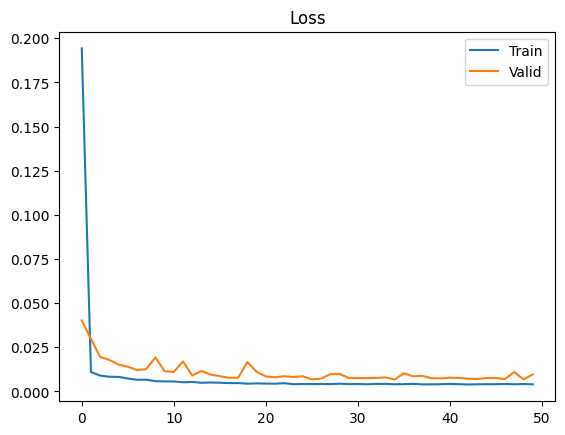

In [10]:
fig, ax = plt.subplots()
ax.plot(history['train_loss'], label='Train')
ax.plot(history['valid_loss'], label='Valid')
ax.set_title('Loss')
ax.legend()
plt.show()

## Evaluation



  0%|          | 0/47 [00:00<?, ?it/s]

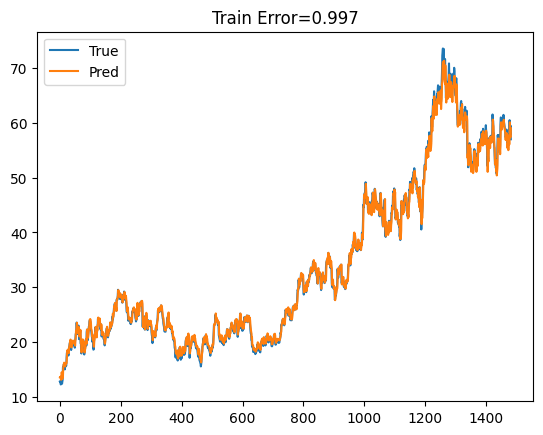

  0%|          | 0/8 [00:00<?, ?it/s]

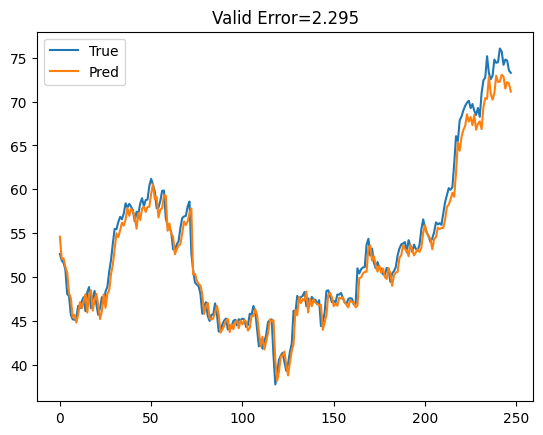

In [11]:
@torch.no_grad()
def evaluate(dataset):
    model.eval()
    preds = []
    trues = []
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    for feature_b, target_b in tqdm(iter(loader)):
        predict_b = model(feature_b.to(device)).to("cpu")
        preds.extend(predict_b)
        trues.extend(target_b)
    preds = torch.stack(preds).numpy() # [N]
    trues = torch.stack(trues).numpy() # [N]
    return preds, trues


preds, trues = evaluate(train_set)
preds = preds * std.scale_[1] + std.mean_[1]
trues = trues * std.scale_[1] + std.mean_[1]
error = ((preds - trues) ** 2).mean()
fig, ax = plt.subplots()
ax.plot(trues, label='True')
ax.plot(preds, label='Pred')
ax.set_title(f'Train Error={error:.3f}')
ax.legend()
plt.show()

preds, trues = evaluate(valid_set)
preds = preds * std.scale_[1] + std.mean_[1]
trues = trues * std.scale_[1] + std.mean_[1]
error = ((preds - trues) ** 2).mean()
fig, ax = plt.subplots()
ax.plot(trues, label='True')
ax.plot(preds, label='Pred')
ax.set_title(f'Valid Error={error:.3f}')
ax.legend()
plt.show()





  0%|          | 0/55 [00:00<?, ?it/s]

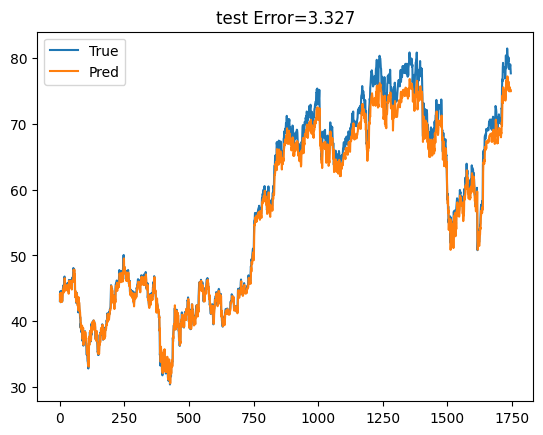

In [12]:
preds, trues = evaluate(test_set)
preds = preds * std.scale_[1] + std.mean_[1]
trues = trues * std.scale_[1] + std.mean_[1]
error = ((preds - trues) ** 2).mean()
fig, ax = plt.subplots()
ax.plot(trues, label='True')
ax.plot(preds, label='Pred')
ax.set_title(f'test Error={error:.3f}')
ax.legend()
plt.show()

## Useful DataFrame methods

1. Use `df.values` to get the underlying ndarray, and use `ndarray` operations.
2. **Use Excel, by hand or other tools you want to calculate the values.**



In [13]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market

df_ual = df_all[df_all['symbol'] == 'UAL']              # select entries that has symbol 'UAL'
# df_ual = df_all[df_all['symbol'].isin(['UAL', 'WU'])] # another way, but can select multiple companies
df_ual = df_ual.reset_index(drop=True)                  # Reset the index to 0, 1, ..., 1761

print(df_ual)

df_ual = df_ual.drop(columns=['symbol', 'date'])        # drop symbol & date columns
data_ual = df_ual.values                                # get its underlying ndarray

print(data_ual.shape)
print(data_ual[:10])

            date symbol       open      close        low       high  \
0     2010-01-04    UAL  12.990000  12.800000  12.530000  13.110000   
1     2010-01-05    UAL  12.870000  13.910000  12.870000  14.100000   
2     2010-01-06    UAL  13.740000  13.270000  13.130000  13.990000   
3     2010-01-07    UAL  13.200000  13.550000  13.200000  13.950000   
4     2010-01-08    UAL  13.560000  13.330000  13.130000  13.860000   
...          ...    ...        ...        ...        ...        ...   
1757  2016-12-23    UAL  74.400002  74.790001  74.129997  74.830002   
1758  2016-12-27    UAL  74.779999  74.669998  74.500000  75.220001   
1759  2016-12-28    UAL  75.000000  73.529999  73.349998  75.180000   
1760  2016-12-29    UAL  73.529999  73.279999  72.930000  74.190002   
1761  2016-12-30    UAL  73.430000  72.879997  72.370003  73.430000   

          volume  
0      8785900.0  
1     23646300.0  
2     15398700.0  
3     10177000.0  
4      5896400.0  
...          ...  
1757   1616800

In [14]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market
df_all = df_all.drop(columns=['date'])

for symbol, group in df_all.groupby('symbol'):          # iterate different companies. group is a DataFrame that is subset of df_all
    print('symbol:', symbol, 'shape:', group.shape)
    print(group.sample(3))                              # print random 3 entries
    group = group.drop(columns=['symbol'])              # drop symbol columns
    print('mean:', group.mean(axis=0).values)           # compute mean of rest columns respectively
    print('-' * 10)

symbol: A shape: (1762, 6)
       symbol       open      close        low       high     volume
486216      A  41.595134  40.164520  40.114448  41.831188  4095100.0
524358      A  40.278969  40.257511  40.078682  40.414879  1664400.0
196460      A  26.294707  26.373391  26.072962  27.224607  7548600.0
mean: [3.40652898e+01 3.40802207e+01 3.37141014e+01 3.44148416e+01
 3.92758910e+06]
----------
symbol: AAL shape: (1762, 6)
       symbol       open      close        low       high      volume
592819    AAL  51.680000  49.970001  49.900002  51.700001  15364000.0
543919    AAL  42.720001  43.330002  42.650002  43.660000  10166700.0
709439    AAL  41.939999  42.299999  41.889999  42.730000   6545500.0
mean: [2.38751078e+01 2.38737684e+01 2.34664529e+01 2.42839331e+01
 9.35403802e+06]
----------
symbol: AAP shape: (1762, 6)
       symbol        open       close         low        high     volume
150031    AAP   65.150002   65.650002   64.559998   65.930000  1418100.0
68501     AAP   53.2099

In [15]:
df_all = pd.read_csv(csv_path_all).sort_values('date')  # read all data of stock market
df_all = df_all.drop(columns=['date'])

groups = [] # Select those companies that has 1762 entries and symbol is started with 'Y'
for symbol, group in df_all.groupby('symbol'):          # iterate different companies. group is a DataFrame that is subset of df_all
    if len(group) == 1762 and symbol.startswith('Y'):
        groups.append(group)
df = pd.concat(groups)                                  # Concatenate those groups
df = df.reset_index(drop=True)                          # Reset the index to 0, 1, ..., 1761

print(df.shape)
print(df['symbol'].unique())                            # Companies

(3524, 6)
['YHOO' 'YUM']
